In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

In [3]:
#import datetime as dt
from datetime import datetime as dt, timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect#delete 

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(engine, reflect = True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Check columns for 'measurement' table
inspector = inspect(engine)
tests = inspector.get_columns('measurement')
print("Columns in 'measurement':")
for test in tests:
    print (test['name'], test['type'])
    
# Check columns for 'station' table
tests = inspector.get_columns('station')
print("\nColumns in 'station':")
for test in tests:
    print (test['name'], test['type'])

Columns in 'measurement':
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Columns in 'station':
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Climate Analysis
### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [11]:
# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

last_year_date = dt.strptime(latest_date[0], "%Y-%m-%d") # string to date
last_year_date = last_year_date - timedelta(days=365) # date - days
last_year_date = last_year_date.strftime("%Y-%m-%d") # date to string

print(f"Date of the last data point: {latest_date[0]}")
print(f"Date one year ago from the last data point: {last_year_date}")

Date of the last data point: 2017-08-23
Date one year ago from the last data point: 2016-08-23


In [12]:
# Perform a query to retrieve the data and precipitation scores
year_precip = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= last_year_date).all()
year_precip

[('2016-08-23', 0.0),
 ('2016-08-24', 0.08),
 ('2016-08-25', 0.08),
 ('2016-08-26', 0.0),
 ('2016-08-27', 0.0),
 ('2016-08-28', 0.01),
 ('2016-08-29', 0.0),
 ('2016-08-30', 0.0),
 ('2016-08-31', 0.13),
 ('2016-09-01', 0.0),
 ('2016-09-02', 0.0),
 ('2016-09-03', 0.0),
 ('2016-09-04', 0.03),
 ('2016-09-05', None),
 ('2016-09-06', None),
 ('2016-09-07', 0.05),
 ('2016-09-08', 0.0),
 ('2016-09-09', 0.03),
 ('2016-09-10', 0.0),
 ('2016-09-11', 0.05),
 ('2016-09-12', 0.0),
 ('2016-09-13', 0.02),
 ('2016-09-14', 1.32),
 ('2016-09-15', 0.42),
 ('2016-09-16', 0.06),
 ('2016-09-17', 0.05),
 ('2016-09-18', 0.0),
 ('2016-09-19', 0.0),
 ('2016-09-20', 0.0),
 ('2016-09-21', 0.0),
 ('2016-09-22', 0.02),
 ('2016-09-23', 0.0),
 ('2016-09-24', 0.0),
 ('2016-09-25', 0.0),
 ('2016-09-26', 0.06),
 ('2016-09-27', 0.02),
 ('2016-09-28', 0.0),
 ('2016-09-29', 0.0),
 ('2016-09-30', 0.0),
 ('2016-10-01', 0.0),
 ('2016-10-02', 0.0),
 ('2016-10-03', 0.0),
 ('2016-10-04', 0.0),
 ('2016-10-05', 0.0),
 ('2016-10-06'

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(year_precip, columns = ['date', 'precipitation'])
precip_df.set_index('date', inplace = True)
# Sort the dataframe by date
precip_df.sort_index(inplace=True)

precip_df

,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
...,...
2017-08-22,0.00
2017-08-23,0.00
2017-08-23,0.00


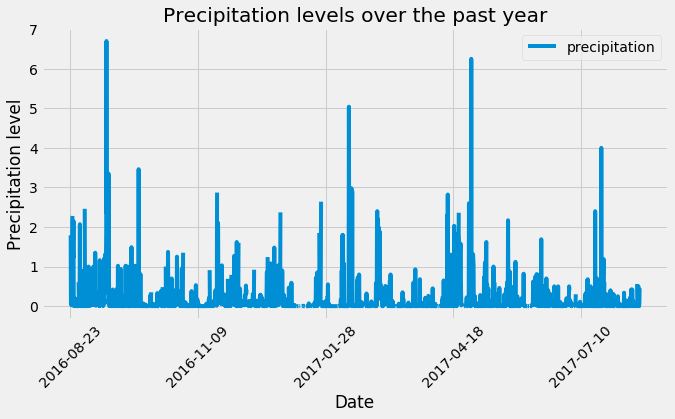

In [14]:
# Use dataframe 'plot' method to plot the data
#Pandas Plotting with Matplotlib to plot the data
#, fontsize = 10
fig, ax = plt.subplots()
precip_df.plot(ax=ax, rot=45, figsize =(10,5))
ax.set_title("Precipitation levels over the past year")
ax.set_ylabel("Precipitation level")
ax.set_xlabel("Date")
plt.savefig('visualizations/prcp_year.png', bbox_inches = 'tight')

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station.station).count()
print(stations)

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())
for station in stations:
    print(station)

most_active_station = session.query(Station.name).\
    filter(Station.station == stations[0][0]).all()
print(f"\nThe most active station is {stations[0][0]} ({most_active_station[0][0]}).")

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)

The most active station is USC00519281 (WAIHEE 837.5, HI US).


In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
active_desc = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == stations[0][0])

print(f"The lowest temperature recorded at the most active station {most_active_station[0][0]} is {active_desc[0][0]}, while the highest temperature recorded is {active_desc[0][1]}.")
print(f"The average temperature is {round(active_desc[0][2], 2)}.")

The lowest temperature recorded at the most active station WAIHEE 837.5, HI US is 54.0, while the highest temperature recorded is 85.0.
The average temperature is 71.66.


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station
active_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == stations[0][0]).\
    filter(Measurement.date >= last_year_date).all()
# Create a dataframe to hold data retrieved
active_temp_df = pd.DataFrame(active_temp)
active_temp_df

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


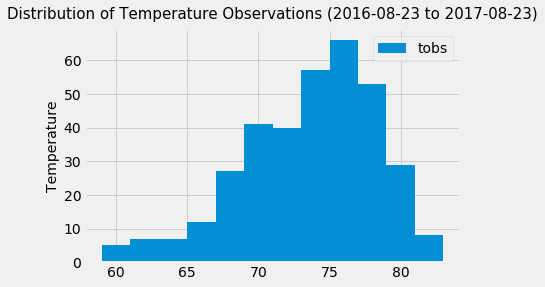

In [20]:
# Plot the results as a histogram
active_temp_df.plot(kind = 'hist', bins=12)
plt.title(f"Distribution of Temperature Observations ({last_year_date} to {latest_date[0]})", fontsize = 15, pad = 10)
plt.ylabel("Temperature", fontsize = 14)
plt.savefig('visualizations/tobs_hist.png', bbox_inches = 'tight')

# Bonus Challenge Assignment
### Temperature Analysis I

* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?

* You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.

* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.

* Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [21]:
june_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == "06")
    #filter(dt.strptime(Measurement.date, '%m') == '06').all()
june_temp_df = pd.DataFrame(june_temp)
dec_temp = session.query(Measurement.date, Measurement.tobs).\
    filter(func.strftime("%m", Measurement.date) == '12').all()
dec_temp_df = pd.DataFrame(dec_temp)
#latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

print(june_temp_df)
print(dec_temp_df)

            date  tobs
0     2010-06-01  78.0
1     2010-06-02  76.0
2     2010-06-03  78.0
3     2010-06-04  76.0
4     2010-06-05  77.0
...          ...   ...
1695  2017-06-26  79.0
1696  2017-06-27  74.0
1697  2017-06-28  74.0
1698  2017-06-29  76.0
1699  2017-06-30  75.0

[1700 rows x 2 columns]
            date  tobs
0     2010-12-01  76.0
1     2010-12-03  74.0
2     2010-12-04  74.0
3     2010-12-06  64.0
4     2010-12-07  64.0
...          ...   ...
1512  2016-12-27  71.0
1513  2016-12-28  71.0
1514  2016-12-29  69.0
1515  2016-12-30  65.0
1516  2016-12-31  65.0

[1517 rows x 2 columns]


In [22]:
# Identify the average temperatures for each month
avg_temp = pd.DataFrame([{"Month":"June", "Avg Temp":june_temp_df["tobs"].mean()},
                        {"Month":"December", "Avg Temp":dec_temp_df["tobs"].mean()}])
avg_temp

,Month,Avg Temp
0,June,74.944118
1,December,71.041529


I used an unpaired t-test to determine whether the difference in the means, if any, is statistically significant, because we are comparing the mean temperatures at two different time points that aren't dependent on each other.

**Null hypothesis (H0):** The difference between the mean temperatures of months June and December is equal to zero.<br />**Alternative hypothesis (H1):** The difference between the mean temperatures of months June and December is not equal to zero.

In [23]:
stats.ttest_ind(june_temp_df["tobs"], dec_temp_df["tobs"])

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

As the p-value is less than 0.05, we reject the null hypothesis of equal averages and accept the alternative hypothesis that the difference between the means is statistically significant between temperatures of months June and December.

### Temperature Analysis II 

In [24]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


**Vacation dates: 2018-05-15 to 2018-5-24**

In [25]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = '2018-05-15'
trip_end = '2018-05-24'
# To use the previous year's data
last_yr_start = (dt.strptime(trip_start, "%Y-%m-%d") - timedelta(days=365)).strftime("%Y-%m-%d")
last_yr_end = (dt.strptime(trip_end, "%Y-%m-%d") - timedelta(days=365)).strftime("%Y-%m-%d")
tmin, tave, tmax = calc_temps(last_yr_start, last_yr_end)[0]

print(f"Using data from {last_yr_start} to {last_yr_end}")
print("-----------------------------------------")
print(f"Lowest temperature: {tmin}")
print(f"Average temperature: {tave}")
print(f"Highest temperature: {tmax}")

Using data from 2017-05-15 to 2017-05-24
-----------------------------------------
Lowest temperature: 68.0
Average temperature: 74.70175438596492
Highest temperature: 87.0


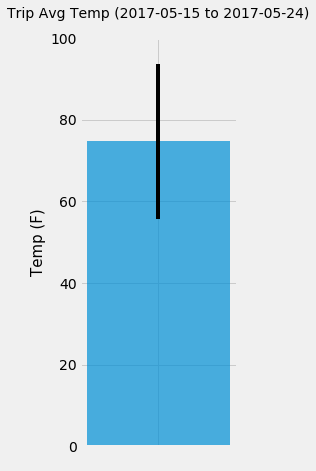

In [26]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

plt.figure(figsize=(2.5, 7))
plt.bar(x = " ", height = tave, yerr = tmax-tmin, alpha = 0.7)
plt.ylim(0, 100)
plt.title(f"Trip Avg Temp ({last_yr_start} to {last_yr_end})", fontsize = 14, pad = 20)
plt.ylabel("Temp (F)", fontsize = 15)

plt.savefig('visualizations/trip_avg_temp.png', bbox_inches = 'tight')

### Daily Rainfall Average 

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
rain_per_station = session.query(Station.station, 
                                 Station.name,
                                 func.sum(Measurement.prcp),
                                 Station.latitude, 
                                 Station.longitude, 
                                 Station.elevation).\
    filter(Measurement.date >= last_yr_start).\
    filter(Measurement.date <= last_yr_end).\
    filter(Measurement.station == Station.station).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc())
  
rain_per_station_df = pd.DataFrame(rain_per_station, columns = ["Station", "Name", "Total Rainfall", "Latitude", "Longitude", "Elevation"])
rain_per_station_df

,Station,Name,Total Rainfall,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",3.87,21.33310,-157.80250,152.4
1,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",1.13,21.33556,-157.71139,19.5
2,USC00513117,"KANEOHE 838.1, HI US",0.84,21.42340,-157.80150,14.6
3,USC00519281,"WAIHEE 837.5, HI US",0.78,21.45167,-157.84889,32.9
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.44,21.52130,-157.83740,7.0
5,USC00519397,"WAIKIKI 717.2, HI US",0.28,21.27160,-157.81680,3.0


In [28]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# Function usage example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [29]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals = []

#trip_start = '2018-05-15'
#trip_end = '2018-05-24'
trip_start_date = dt.strptime(trip_start, "%Y-%m-%d")
trip_end_date = dt.strptime(trip_end, "%Y-%m-%d")

# Use the start and end dates to create a range of dates
trip_range = trip_end_date - trip_start_date # output: 9 days, 0:00:00

# Strip off the year and save a list of %m-%d strings
trip_dates = []
for n in range(trip_range.days + 1): # n = 0 to 9
    date = trip_start_date + timedelta(days = n)
    trip_dates.append(dt.strftime(date, "%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
for n in trip_dates:
    normals.append(daily_normals(n)[0])
    
print(normals)

[(63.0, 73.69090909090909, 79.0), (68.0, 74.37931034482759, 80.0), (68.0, 74.45, 79.0), (68.0, 74.10714285714286, 82.0), (65.0, 73.80701754385964, 79.0), (68.0, 73.89655172413794, 79.0), (64.0, 72.96428571428571, 80.0), (64.0, 74.45614035087719, 80.0), (68.0, 74.94827586206897, 87.0), (67.0, 73.94827586206897, 79.0)]


In [30]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_daily_norms = pd.DataFrame(normals, columns = ["tmin", "tavg", "tmax"])
trip_daily_norms["date"] = trip_dates
trip_daily_norms.set_index('date', inplace = True)
trip_daily_norms

,tmin,tavg,tmax
date,,,
05-15,63.0,73.690909,79.0
05-16,68.0,74.379310,80.0
05-17,68.0,74.450000,79.0
05-18,68.0,74.107143,82.0
05-19,65.0,73.807018,79.0
05-20,68.0,73.896552,79.0
05-21,64.0,72.964286,80.0
05-22,64.0,74.456140,80.0
05-23,68.0,74.948276,87.0


<Figure size 720x2160 with 0 Axes>

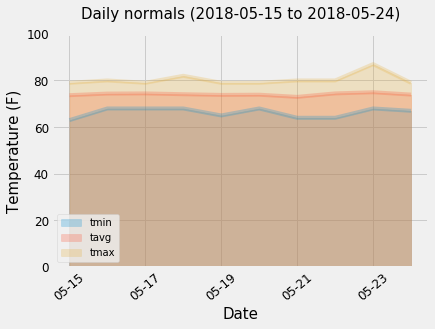

In [31]:
# Plot the daily normals as an area plot with `stacked=False`
plt.figure(figsize=(10, 30))
trip_daily_norms.plot(kind = "area", stacked = False, rot = 40, alpha = .25, fontsize = 12)
plt.title(f"Daily normals ({trip_start} to {trip_end})", fontsize = 15, pad = 15)
plt.xlabel("Date", fontsize = 15)
plt.ylabel("Temperature (F)", fontsize = 15)
plt.ylim(0,100)
plt.legend(loc = 'best', prop={'size': 10})
plt.savefig('visualizations/trip_daily_area.png',bbox_inches = 'tight')